In [1]:
# este codigo importa las librerías que se usan mas adelante para el analisis y para el modelo

# librerias para trabar datos
import pandas as pd
import numpy as np

# librerias para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# librerias para crear modelos
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf


In [2]:
# esta funcion permite ver la base completa, en las columnas, para poder visualizar todas las columnas
pd.options.display.max_columns = 50

In [3]:
# importación de las bases 
# se dejan los parametros sep para indicar el separador, el parametro decimal para indicar como están separados los decimales y el parametro encoding para especificar la codificación del archivo
expo = pd.read_csv("Exportaciones.txt",sep = "|",decimal=",",encoding="='utf-8")
Directorio_DANE = pd.read_csv("Directorio_DANE.txt",sep = "|",decimal=",",encoding="='utf-8")
SuperSociedades = df = pd.read_csv("Supersociedades.txt",sep = "|",decimal=",",encoding="='utf-8")
RUES = df = pd.read_csv("RUES.txt",sep = "|",decimal=",",encoding="='utf-8")

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12048\1210664618.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  RUES = df = pd.read_csv("RUES.txt",sep = "|",decimal=",",encoding="='utf-8")


In [4]:
# unir las bases para tener una consolidada
df = pd.concat([expo,Directorio_DANE,SuperSociedades,RUES]).sort_values(['NIT'])

# asignación del tipo de variable a las variables de la base 
df=df.astype({'NIT':'Int64','Cod. Depto': 'str','Departamento': 'category','Cod. Municipio':'str','Municipio':'str','CIIU Rev 4 principal':'str','Descripción CIIU principal':'category',
                        'Cadena CIIU principal':'category','Valor agregado empresa':'category','Activos':'float64','Ingresos operacionales':'float64','Tamaño empresa RUES':'category',
                        'Sucursal sociedad extranjera':'str','País domicilio casa matriz':'str','Antigüedad empresa':'float64','Tipo* ult 10 años':'str','Cadena* ult 10 años':'str',
                        'Sector* ult 10 años':'str','Subsector* ult 10 años':'str','Posara* ult 10 años':'str','Descripcion posara* ult 10 años':'str','Cod. Departamento* ult 10 años':'str',
                        'Departamento* ult 10 años':'str','Expo Latam ult 10 años':'category','Expo 2022':'float64','Expo prom ult 5 años':'float64','Var. Expo 2022':'float64',
                        'TCAC expo ult 5 años':'float64','Trayectoria expo':'str','Cadena segmentación':'category'})

# se borran unas columnas que contienen la misma información que otras pero al no estar estandarizada entre bases generan duplicados y no dejan analizar correctamente la información. Ej : En cod. Depto aparecen 05 - 5
df.drop(['CIIU Rev 4 principal','Cod. Municipio','Cod. Departamento* ult 10 años','Cod. Depto'],axis = 1,inplace=True)

# eliminar los duplicados que se tenian entre las bases 
df.drop_duplicates(inplace=True,ignore_index=True)

# creación de variables que pueden permitir un analisis menos complejo
df['exporta'] = df['Expo 2022'].apply(lambda x: "1" if x >0 else "0" )
df['exporta5m'] = df['Expo prom ult 5 años'].apply(lambda x: 1 if x >0 else 0 )
df['matriz_domicilio_extranjera'] = df["País domicilio casa matriz"].apply(lambda x: "1" if x in ("No es sucursal de sociedad extranjera","No determinado") else "0" ) 


In [5]:
df.groupby(['matriz_domicilio_extranjera'])['NIT'].count()
# identificamos que la variable matriz_domicilio_extranjera solo cuenta con 13 observaciones en 0, por la falta de varianza no termina siendo útil
# se hizo el mismo ejercicio iterando con distintas variables para ver su varianza y ver su posible aplicación en un modelo

matriz_domicilio_extranjera
0       13
1    49987
Name: NIT, dtype: Int64

otras variables como TCAC expo ult 5 año tienen muy poca información y muy desbalanceada entre los que han exportado y los que no por lo que no se puede usar para generar analisis estadistico \
tampoco se incluyen variables que agrupen indicadores de la exportación para no generar problemas de correlación al momento de hacer el modelo

In [6]:
# se renombran algunas columnas para poder usarlas en los modelos
df.rename(columns={"Expo 2022":"expo","Ingresos operacionales":"ingresos_operacionales","Valor agregado empresa":"valor_agregado","Expo Latam ult 10 años":"expo_latam","Cadena CIIU principal":"cadena_CIIU"
                   ,"Cadena segmentación":"cadena_segmentacion","Antigüedad empresa":"antiguedad_empresa",'Tamaño empresa RUES':'tamano_empresa'},inplace=True)

# identificación variables de la base

In [7]:
# se crea una agrupacion para identificar que tamaño de la base exporta
df.groupby('exporta').count()['NIT']

exporta
0    48939
1     1061
Name: NIT, dtype: Int64

In [8]:
df[df['exporta']=="1"].groupby(['Departamento']).count()['NIT'].sort_values(ascending=False).head(3)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12048\453169264.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['exporta']=="1"].groupby(['Departamento']).count()['NIT'].sort_values(ascending=False).head(3)


Departamento
Bogotá, D.C.       376
Antioquia          228
Valle del Cauca    110
Name: NIT, dtype: Int64

In [9]:
df[df['exporta']=="1"].groupby(['expo_latam']).count()['NIT']

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12048\79274111.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['exporta']=="1"].groupby(['expo_latam']).count()['NIT']


expo_latam
No    207
Si    854
Name: NIT, dtype: Int64

In [10]:
df[df['exporta']=="1"].groupby(['Trayectoria expo']).count()['NIT'].sort_values(ascending=False).head(3)

Trayectoria expo
Pymex           475
No Constante    272
Futuros         246
Name: NIT, dtype: Int64

In [11]:
print(df[df['exporta']=="1"]['ingresos_operacionales'].mean())
print(df[df['exporta']!="1"]['ingresos_operacionales'].mean())

44195867859.90158
1842184002.9072227


In [12]:
print(df[df['exporta']=="1"].groupby(['valor_agregado']).count()['NIT'].sort_values(ascending=False).head(3))
print(df[df['exporta']!="1"].groupby(['valor_agregado']).count()['NIT'].sort_values(ascending=False).head(3))
df['valor_agregado'].unique()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12048\3611694756.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[df['exporta']=="1"].groupby(['valor_agregado']).count()['NIT'].sort_values(ascending=False).head(3))
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12048\3611694756.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[df['exporta']!="1"].groupby(['valor_agregado']).count()['NIT'].sort_values(ascending=False).head(3))


valor_agregado
Servicios menos intensivos en conocimiento    300
Bienes tecnología baja                        274
Bienes tecnología media-baja                  126
Name: NIT, dtype: Int64
valor_agregado
Servicios menos intensivos en conocimiento         9140
Servicios no clasificados                          8381
Servicios de mercado intensivos en conocimiento    7626
Name: NIT, dtype: Int64


['Servicios menos intensivos en conocimiento', 'Bienes tecnología alta', 'Bienes primarios', 'Bienes tecnología media-alta', 'Servicios de mercado intensivos en conocimiento', ..., 'No determinado', 'Servicios no clasificados', 'Bienes tecnología baja', 'Bienes tecnología media-baja', 'Otros servicios intensivos en conocimiento']
Length: 11
Categories (11, object): ['Bienes primarios', 'Bienes tecnología alta', 'Bienes tecnología baja', 'Bienes tecnología media-alta', ..., 'Servicios de alta tecnología intensivos en co..., 'Servicios de mercado intensivos en conocimiento', 'Servicios menos intensivos en conocimiento', 'Servicios no clasificados']

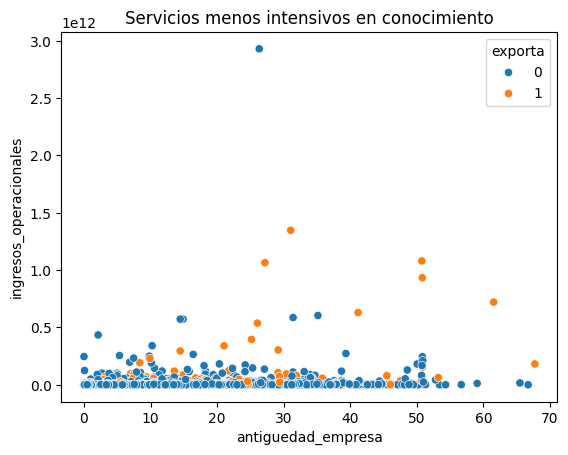

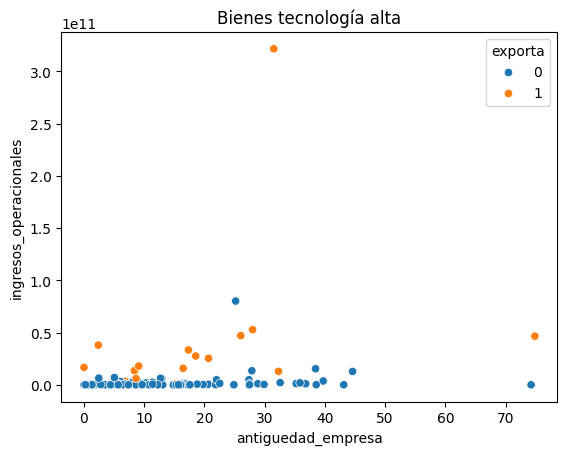

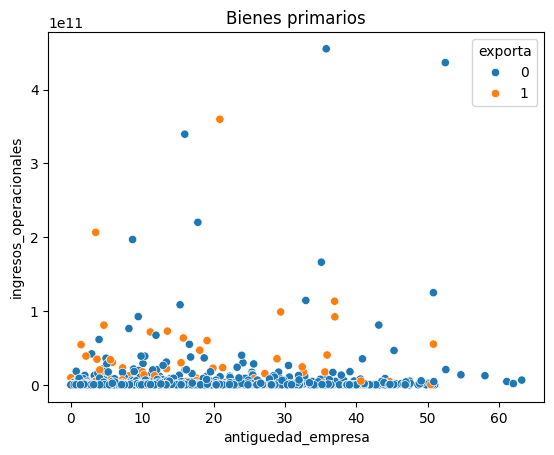

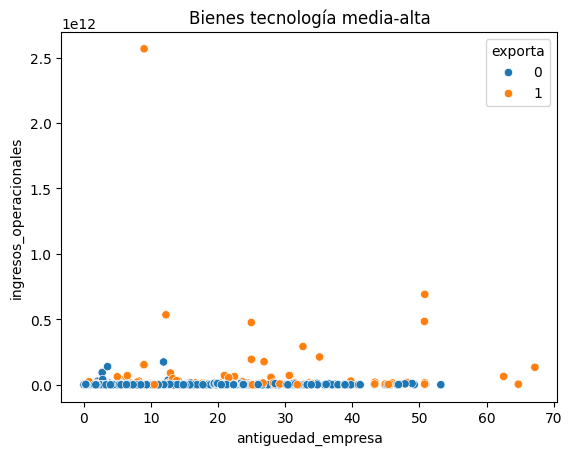

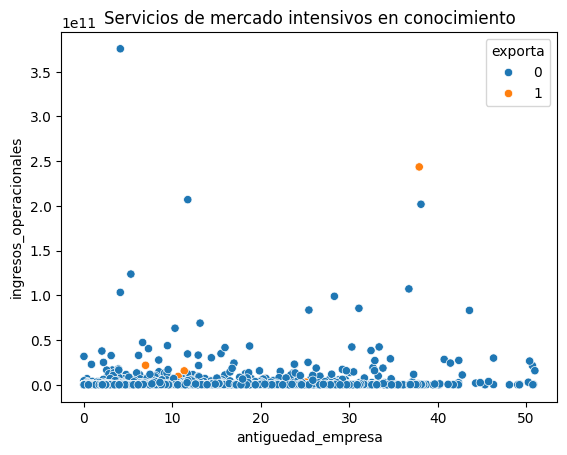

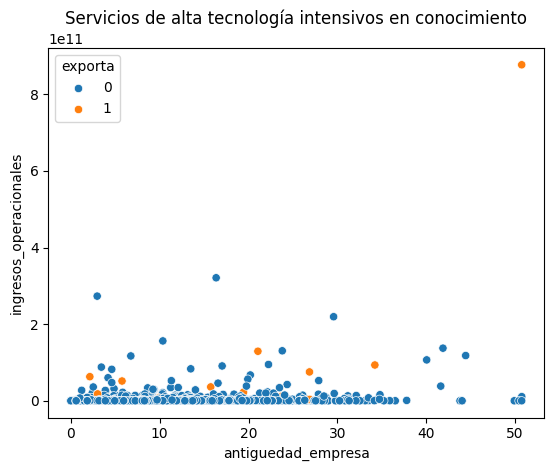

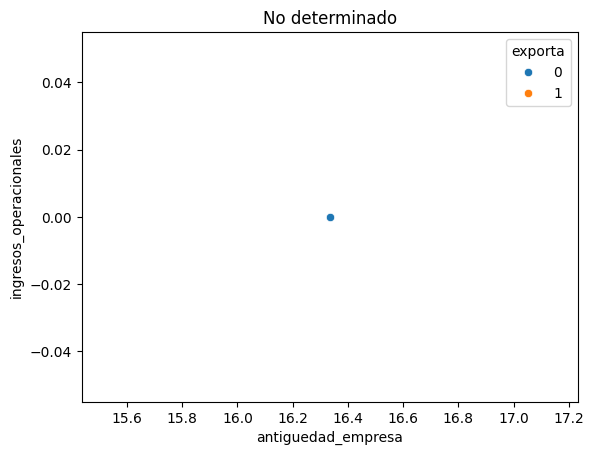

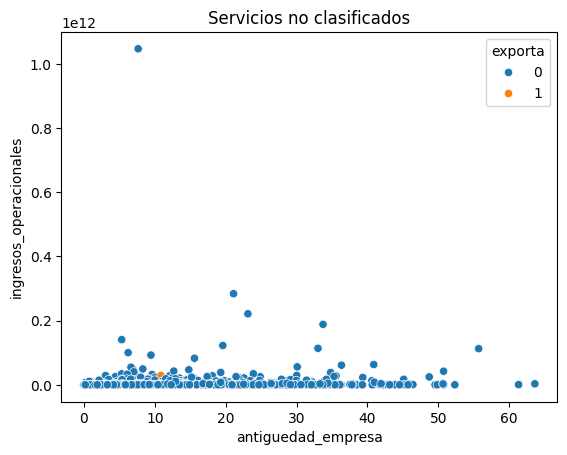

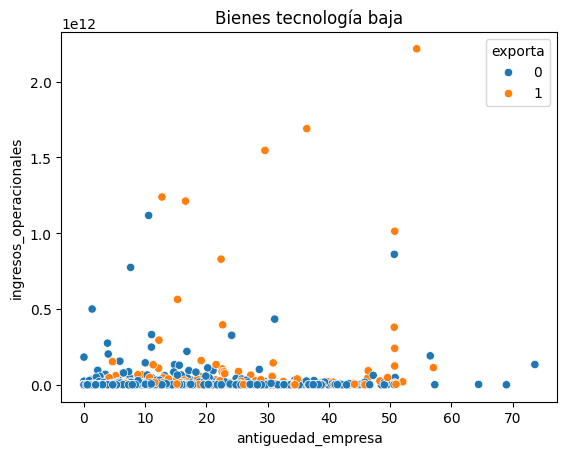

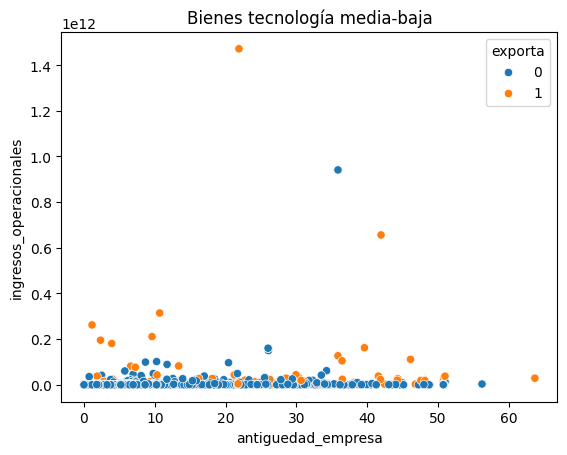

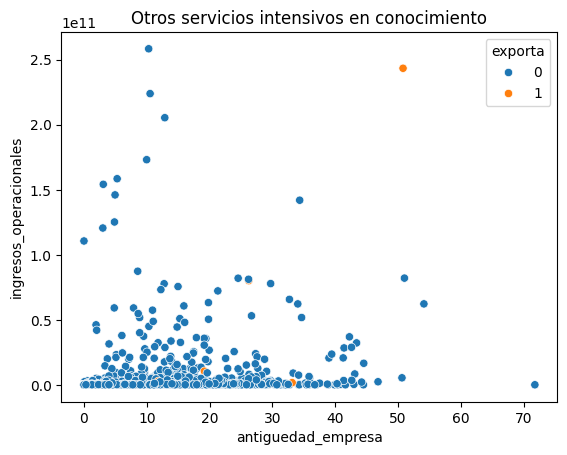

In [13]:
# se hacen multiples graficos y se quita un outlier para poder hacer mejr la visualización, se miraba una relación entre ingresos y antigüedad para los diferentes grupos de valor agregado
plt.figure()
for i in df['valor_agregado'].unique():
    
    # ax[j,0]
    sns.scatterplot(data = df[(df['ingresos_operacionales']<5000000000000)&(df['valor_agregado']==i)],y='ingresos_operacionales',x='antiguedad_empresa',hue='exporta').set(title=i)
    plt.show()

# MODELOS

In [14]:
# se prueba el primer modelo con distintas formulas, no se logra un poder explicativo del modelo alto por lo que se decide ir con otro 
model_ols = smf.ols(formula='expo ~ ingresos_operacionales + C(cadena_CIIU)*ingresos_operacionales', data=df[df['expo']>0]).fit()
model_ols.summary()
# df.head(1)

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   expo   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     33.92
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.65e-87
Time:                        03:31:23   Log-Likelihood:                -18885.
No. Observations:                1061   AIC:                         3.781e+04
Df Residuals:                    1043   BIC:                         3.790e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================
                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      2.345e+06   8.23e+05      2.849      0.004     7.3e+05    3.96e+06
C(cadena_CIIU)[T.CIIU no aplica categoría ProColombia]                        -2.364e+06   1.62e+06     -1.456      0.146   -5.55e+06    8.21e+05
C(cadena_CIIU)[T.Industrias 4.0]                                               3.885e+05    2.1e+06      0.185      0.853   -3.73e+06     4.5e+06
C(cadena_CIIU)[T.Infraestructura ]                                            -2.142e+06   1.16e+07     -0.184      0.854    -2.5e+07    2.07e+07
C(cadena_CIIU)[T.Logística ]                                                  -2.326e+06   1.43e+07     -0.162      0.871   -3.04e+07    2.58e+07
C(cadena_CIIU)[T.Logística e Infraestructura ]                                    3.2350    118.552      0.027      0.978    -229.392     235.862
C(cadena_CIIU)[T.Metalmecánica y Otras Industrias]                            -2.536e+06   1.23e+06     -2.068      0.039   -4.94e+06    -1.3e+05
C(cadena_CIIU)[T.Mineras]                                                       -12.4108     65.361     -0.190      0.849    -140.665     115.843
C(cadena_CIIU)[T.No determinado]                                              -9.408e+05   9.98e+05     -0.943      0.346    -2.9e+06    1.02e+06
C(cadena_CIIU)[T.Químicos y Ciencias de la Vida]                              -1.313e+06   1.29e+06     -1.014      0.311   -3.85e+06    1.23e+06
C(cadena_CIIU)[T.Sistema Moda]                                                -2.342e+06   1.32e+06     -1.780      0.075   -4.92e+06     2.4e+05
C(cadena_CIIU)[T.Turismo]                                                     -2.492e-09    1.5e-08     -0.166      0.868    -3.2e-08     2.7e-08
ingresos_operacionales                                                         5.577e-05   3.23e-06     17.288      0.000    4.94e-05    6.21e-05
C(cadena_CIIU)[T.CIIU no aplica categoría ProColombia]:ingresos_operacionales   -2.7e-05    1.3e-05     -2.082      0.038   -5.24e-05   -1.56e-06
C(cadena_CIIU)[T.Industrias 4.0]:ingresos_operacionales                       -1.865e-05   1.11e-05     -1.673      0.095   -4.05e-05    3.22e-06
C(cadena_CIIU)[T.Infraestructura ]:ingresos_operacionales                     -6.166e-05      0.001     -0.092      0.927      -0.001       0.001
C(cadena_CIIU)[T.Logística ]:ingresos_operacionales                           -4.658e-05      0.026     -0.002      0.999      -0.050       0.050
C(cadena_CIIU)[T.Logística e Infraestructura ]:ingresos_operacionales            -0.1291      0.723     -0.178      0.858      -1.548       1.290
C(cadena_CIIU)[T.

In [15]:
# se vuelven unas variables categoricas con codigo para usarlas en los modelos que siguen
df['C_valor_agregado']=df['valor_agregado'].cat.codes
df['C_Departamento']=df['Departamento'].cat.codes
df['C_tamano_empresa']=df['tamano_empresa'].cat.codes
df['C_cadena_segmentacion']=df['cadena_segmentacion'].cat.codes
df['C_Descripción CIIU principal']=df['Descripción CIIU principal'].cat.codes
df['C_cadena_CIIU']=df['cadena_CIIU'].cat.codes
df['C_expo_latam']=df['expo_latam'].cat.codes
df['C_valor_agregado']=df['valor_agregado'].cat.codes

# para estas variables que tienen nulos en menos del 5% de la base se les imputa un valor, que es el promedio para poder usarlos
df['antiguedad_empresa']=df['antiguedad_empresa'].fillna(df['antiguedad_empresa'].mean())
df['Activos']=df['Activos'].fillna(df['Activos'].mean())


## Bosque aleatorio para categorizar
en este ejercicio se prueba un bosque aleatorio para encontrar la categoría de los que pueden ser exportadores, se vigila y se optimiza el número de empresas que exporta y el modelo arroja que si exporta

In [16]:

# se deja como primero la base de variables con las que se entrenaran, después de probar varios modelos este set de variables es el más óptimo
# se deja el test_size que es el tamaño con el cual se va a dividir la base de testeo y entrenamiento y el random_state que es para poder replicar el ejercicio y el factor aleatorio no tenga un impacto después 
X_train, X_test, y_train, y_test = train_test_split(df[['ingresos_operacionales','C_valor_agregado','C_expo_latam','exporta5m']],
                                                    df['exporta'], test_size=0.25,
                                                    random_state=100)

# en el modelo RandomForestClassifier eln_estimators se especifica el numero de arboles, se escogío 100 para no hacer un sobre ajuste y tener suficiente y el citerion de entropy que es la funcion que se maximiza 
modelo1 = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 100)
modelo1.fit(X_train, y_train)


# se prueba el desempeño del modelo dentro y fuera del set de entrenamiento y se hace una matriz de confusion para hacer seguimiento a los resultados
y_pred_train = modelo1.predict(X_train)
y_pred_test =modelo1.predict(X_test)

print(f"Accuracy en el conjunto de entrenamiento: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy en otro conjunto: {accuracy_score(y_test, y_pred_test)}")
cm = confusion_matrix(y_test,y_pred_test,labels=["1","0"])
cm

Accuracy en el conjunto de entrenamiento: 0.9980533333333333
Accuracy en otro conjunto: 0.9852


array([[  161,    98],
       [   87, 12154]], dtype=int64)

el anterior modelo nos da una clasificación si la empresa puede ser o no exportadora, para ver el valor que podría exportar y poder priorizar las empresas se hace el mismo modelo en una regresión 

In [17]:
df['expo']=df['expo'].fillna(0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[['ingresos_operacionales','C_valor_agregado','C_expo_latam','exporta5m']],
                                                    df['expo'], test_size=0.25,
                                                    random_state=100)

# se especifica en criterion la función que se quiere maximizar al entrenar el modelo
modelo2 = RandomForestRegressor(n_estimators = 100, criterion = "squared_error", random_state = 100)
modelo2.fit(X_train2, y_train2)

# se hacen las predicciones del modelo y se hace seguimiento el mean_squared_error para escoger entre diferentes modelos
y_pred_train2 = modelo2.predict(X_train2)
y_pred_test2 =modelo2.predict(X_test2)

rmse = mean_squared_error(
        y_true  = y_test2,
        y_pred  = y_pred_test2,
        squared = False
       )
rmse


2018223.4369235716

In [18]:
# se agregan los resultados de los modelos a las bases para conocer cuales empresas son mas propensas
df["modelo1"]=pd.Series(modelo1.predict(df[['ingresos_operacionales','C_valor_agregado','C_expo_latam','exporta5m']]))
df["Valor_a_exportar"]=pd.Series(modelo2.predict(df[['ingresos_operacionales','C_valor_agregado','C_expo_latam','exporta5m']]))

In [19]:
# se hace el filtro en la base y se organiza con el potencial para exportar
df_final = df[(df['modelo1']=="1")&(df['exporta']=="0")][['NIT','Valor_a_exportar']].sort_values(by='Valor_a_exportar',ascending=False)

# se crear el archivo de excel
df_final.to_excel('empresas_con_potencial.xlsx',sheet_name="Empresas",index=False)